## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table

from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2025-02-05 10:41:19.243976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 10:41:19.244021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 10:41:19.272440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 10:41:19.336480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 10:41:20.343584: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-02-05 10:41:23.581517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-05 10:41:23.704721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-05 10:41:23.707496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Load input datasets

In [19]:


# TODO komentáře od Radka 
#
#


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table




# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'parkets/benign/benign_2312_HTML.parquet', 
    'parkets/benign/umbrella_benign_FINISHED_HTML.parquet'
]
malicious_dataset_filenames = [
    'parkets/malware_2406_strict_HTML.parquet'
]

# lex-dga-830k-pick.parquet LABEL je jmeno rodiny
#  'parkets/malware_2406_strict_HTML.parquet'


# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "malware"
# #############################################################

# print labels from malicious datasets


# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
#df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)


ValueError: Target schema's field names are not matching the table's field names: ['domain_name', 'label', 'dns_has_dnskey', 'dns_A_count', 'dns_AAAA_count', 'dns_MX_count', 'dns_NS_count', 'dns_TXT_count', 'dns_SOA_count', 'dns_CNAME_count', 'dns_zone_level', 'dns_zone_digit_count', 'dns_zone_len', 'dns_zone_entropy', 'dns_resolved_record_types', 'dns_dnssec_score', 'dns_ttl_avg', 'dns_ttl_stdev', 'dns_ttl_low', 'dns_ttl_mid', 'dns_ttl_distinct_count', 'dns_soa_primary_ns_level', 'dns_soa_primary_ns_digit_count', 'dns_soa_primary_ns_len', 'dns_soa_primary_ns_entropy', 'dns_soa_email_level', 'dns_soa_email_digit_count', 'dns_soa_email_len', 'dns_soa_email_entropy', 'dns_soa_refresh', 'dns_soa_retry', 'dns_soa_expire', 'dns_soa_min_ttl', 'dns_domain_name_in_mx', 'dns_mx_avg_len', 'dns_mx_avg_entropy', 'dns_txt_avg_len', 'dns_txt_avg_entropy', 'dns_txt_external_verification_score', 'dns_txt_spf_exists', 'dns_txt_dkim_exists', 'dns_txt_dmarc_exists', 'ip_count', 'ip_mean_average_rtt', 'ip_v4_ratio', 'ip_a_aaaa_to_all_ratio', 'ip_entropy', 'ip_as_address_entropy', 'ip_asn_entropy', 'ip_distinct_as_count', 'tls_has_tls', 'tls_chain_len', 'tls_is_self_signed', 'tls_root_authority_hash', 'tls_leaf_authority_hash', 'tls_negotiated_version_id', 'tls_negotiated_cipher_id', 'tls_root_cert_validity_len', 'tls_leaf_cert_validity_len', 'tls_broken_chain', 'tls_expired_chain', 'tls_total_extension_count', 'tls_critical_extensions', 'tls_with_policies_crt_count', 'tls_percentage_crt_with_policies', 'tls_x509_anypolicy_crt_count', 'tls_iso_policy_crt_count', 'tls_joint_isoitu_policy_crt_count', 'tls_subject_count', 'tls_server_auth_crt_count', 'tls_client_auth_crt_count', 'tls_CA_certs_in_chain_ratio', 'tls_unique_SLD_count', 'tls_common_name_count', 'lex_name_len', 'lex_has_digit', 'lex_phishing_keyword_count', 'lex_benign_keyword_count', 'lex_consecutive_chars', 'lex_tld_len', 'lex_tld_abuse_score', 'lex_tld_hash', 'lex_sld_len', 'lex_sld_norm_entropy', 'lex_sld_digit_count', 'lex_sld_digit_ratio', 'lex_sld_phishing_keyword_count', 'lex_sld_vowel_count', 'lex_sld_vowel_ratio', 'lex_sld_consonant_count', 'lex_sld_consonant_ratio', 'lex_sld_non_alphanum_count', 'lex_sld_non_alphanum_ratio', 'lex_sld_hex_count', 'lex_sld_hex_ratio', 'lex_sub_count', 'lex_stld_unique_char_count', 'lex_begins_with_digit', 'lex_www_flag', 'lex_sub_max_consonant_len', 'lex_sub_norm_entropy', 'lex_sub_digit_count', 'lex_sub_digit_ratio', 'lex_sub_vowel_count', 'lex_sub_vowel_ratio', 'lex_sub_consonant_count', 'lex_sub_consonant_ratio', 'lex_sub_non_alphanum_count', 'lex_sub_non_alphanum_ratio', 'lex_sub_hex_count', 'lex_sub_hex_ratio', 'lex_phishing_bigram_matches', 'lex_phishing_trigram_matches', 'lex_phishing_tetragram_matches', 'lex_phishing_pentagram_matches', 'lex_malware_bigram_matches', 'lex_malware_trigram_matches', 'lex_malware_tetragram_matches', 'lex_dga_bigram_matches', 'lex_dga_trigram_matches', 'lex_dga_tetragram_matches', 'lex_avg_part_len', 'lex_stdev_part_lens', 'lex_longest_part_len', 'lex_short_part_count', 'lex_medium_part_count', 'lex_long_part_count', 'lex_superlong_part_count', 'lex_shortest_sub_len', 'lex_ipv4_in_domain', 'lex_has_trusted_suffix', 'lex_has_wellknown_suffix', 'lex_has_cdn_suffix', 'lex_has_vps_suffix', 'lex_has_img_suffix', 'lex_suffix_score', 'geo_countries_count', 'geo_continents_count', 'geo_malic_host_country', 'geo_lat_stdev', 'geo_lon_stdev', 'geo_mean_lat', 'geo_mean_lon', 'geo_min_lat', 'geo_max_lat', 'geo_min_lon', 'geo_max_lon', 'geo_lat_range', 'geo_lon_range', 'geo_centroid_lat', 'geo_centroid_lon', 'geo_estimated_area', 'geo_continent_hash', 'geo_countries_hash', 'rdap_registration_period', 'rdap_domain_age', 'rdap_time_from_last_change', 'rdap_domain_active_time', 'rdap_has_dnssec', 'rdap_registrar_name_len', 'rdap_registrar_name_entropy', 'rdap_registrar_name_hash', 'rdap_registrant_name_len', 'rdap_registrant_name_entropy', 'rdap_admin_name_len', 'rdap_admin_name_entropy', 'rdap_admin_email_len', 'rdap_admin_email_entropy', 'rdap_ip_v4_count', 'rdap_ip_v6_count', 'rdap_ip_shortest_v4_prefix_len', 'rdap_ip_longest_v4_prefix_len', 'rdap_ip_shortest_v6_prefix_len', 'rdap_ip_longest_v6_prefix_len', 'rdap_ip_avg_admin_name_len', 'rdap_ip_avg_admin_name_entropy', 'rdap_ip_avg_admin_email_len', 'rdap_ip_avg_admin_email_entropy', 'html_num_of_tags', 'html_num_of_paragraphs', 'html_num_of_divs', 'html_num_of_titles', 'html_num_of_external_js', 'html_num_of_links', 'html_num_of_scripts', 'html_num_of_scripts_async', 'html_num_of_scripts_type', 'html_num_of_anchors', 'html_num_of_anchors_to_hash', 'html_num_of_anchors_to_https', 'html_num_of_anchors_to_com', 'html_num_of_inputs', 'html_num_of_input_password', 'html_num_of_hidden_elements', 'html_num_of_input_hidden', 'html_num_of_objects', 'html_num_of_embeds', 'html_num_of_frame', 'html_num_of_iframe', 'html_num_of_iframe_src', 'html_num_of_iframe_src_https', 'html_num_of_center', 'html_num_of_imgs', 'html_num_of_imgs_src', 'html_num_of_meta', 'html_num_of_links_href', 'html_num_of_links_href_https', 'html_num_of_links_href_css', 'html_num_of_links_type', 'html_num_of_link_type_app', 'html_num_of_link_rel', 'html_num_of_all_hrefs', 'html_num_of_form_action', 'html_num_of_form_http', 'html_num_of_strong', 'html_no_hrefs', 'html_internal_href_ratio', 'html_num_of_internal_hrefs', 'html_external_href_ratio', 'html_num_of_external_href', 'html_num_of_icon', 'html_icon_external', 'html_num_of_form_php', 'html_num_of_form_hash', 'html_num_of_form_js', 'html_malicious_form', 'html_most_common', 'html_num_of_css_internal', 'html_num_of_css_external', 'html_num_of_anchors_to_content', 'html_num_of_anchors_to_void', 'html_num_of_words', 'html_num_of_lines', 'html_unique_words', 'html_average_word_len', 'html_blocked_keywords_label', 'html_num_of_blank_spaces', 'html_create_element', 'html_write', 'html_char_code_at', 'html_concat', 'html_escape', 'html_eval', 'html_exec', 'html_from_char_code', 'html_link', 'html_parse_int', 'html_replace', 'html_search', 'html_substring', 'html_unescape', 'html_add_event_listener', 'html_set_interval', 'html_set_timeout', 'html_push', 'html_index_of', 'html_document_write', 'html_get', 'html_find', 'html_document_create_element', 'html_window_set_timeout', 'html_window_set_interval', 'html_hex_encoding', 'html_unicode_encoding', 'html_long_variable_name'], ['domain_name', 'label', 'lex_name_len', 'lex_has_digit', 'lex_phishing_keyword_count', 'lex_benign_keyword_count', 'lex_consecutive_chars', 'lex_tld_len', 'lex_tld_abuse_score', 'lex_tld_hash', 'lex_sld_len', 'lex_sld_norm_entropy', 'lex_sld_digit_count', 'lex_sld_digit_ratio', 'lex_sld_phishing_keyword_count', 'lex_sld_vowel_count', 'lex_sld_vowel_ratio', 'lex_sld_consonant_count', 'lex_sld_consonant_ratio', 'lex_sld_non_alphanum_count', 'lex_sld_non_alphanum_ratio', 'lex_sld_hex_count', 'lex_sld_hex_ratio', 'lex_sub_count', 'lex_stld_unique_char_count', 'lex_begins_with_digit', 'lex_www_flag', 'lex_sub_max_consonant_len', 'lex_sub_norm_entropy', 'lex_sub_digit_count', 'lex_sub_digit_ratio', 'lex_sub_vowel_count', 'lex_sub_vowel_ratio', 'lex_sub_consonant_count', 'lex_sub_consonant_ratio', 'lex_sub_non_alphanum_count', 'lex_sub_non_alphanum_ratio', 'lex_sub_hex_count', 'lex_sub_hex_ratio', 'lex_phishing_bigram_matches', 'lex_phishing_trigram_matches', 'lex_phishing_tetragram_matches', 'lex_phishing_pentagram_matches', 'lex_malware_bigram_matches', 'lex_malware_trigram_matches', 'lex_malware_tetragram_matches', 'lex_dga_bigram_matches', 'lex_dga_trigram_matches', 'lex_dga_tetragram_matches', 'lex_avg_part_len', 'lex_stdev_part_lens', 'lex_longest_part_len', 'lex_short_part_count', 'lex_medium_part_count', 'lex_long_part_count', 'lex_superlong_part_count', 'lex_shortest_sub_len', 'lex_ipv4_in_domain', 'lex_has_trusted_suffix', 'lex_has_wellknown_suffix', 'lex_has_cdn_suffix', 'lex_has_vps_suffix', 'lex_has_img_suffix', 'lex_suffix_score']

In [9]:


subsample = 0.08 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample, random_state=42)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)


    
print(f"Total features: {len(df.columns)}")
print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")



KeyError: "['domain_name'] not found in axis"

In [11]:
# print content of column index 
print(df.iloc[:, 0])

23616     malware
776172     benign
558290     benign
27193     malware
726375     benign
           ...   
348917     benign
397228     benign
583370     benign
259299     benign
234250     benign
Name: label, Length: 5870, dtype: object


### Generate subsets of the training dataset

In [12]:
import pandas as pd

# Define prefixes
prefixes = ["dns_", "tls_", "html_", "geo_", "rdap_", "lex_", "ip_"]

# Dictionary to store filtered datasets
subset_dfs = {}

# Create subsets for each prefix
for prefix in prefixes:
    subset_df = df.loc[:, df.columns.str.startswith(prefix) | df.columns.isin(['label'])]
    
    # Store in dictionary
    subset_dfs[prefix] = subset_df

    print(f"Subset '{prefix}' contains {subset_df.shape[1]} features and {subset_df.shape[0]} samples.")
    # print all columns in the subset
    print(subset_df.columns)
    
    
    
## Agregations 

# agregate dns and rdap features and append to prefixes 


Subset 'dns_' contains 41 features and 5870 samples.
Index(['label', 'dns_has_dnskey', 'dns_A_count', 'dns_AAAA_count',
       'dns_MX_count', 'dns_NS_count', 'dns_TXT_count', 'dns_SOA_count',
       'dns_CNAME_count', 'dns_zone_level', 'dns_zone_digit_count',
       'dns_zone_len', 'dns_zone_entropy', 'dns_resolved_record_types',
       'dns_dnssec_score', 'dns_ttl_avg', 'dns_ttl_stdev', 'dns_ttl_low',
       'dns_ttl_mid', 'dns_ttl_distinct_count', 'dns_soa_primary_ns_level',
       'dns_soa_primary_ns_digit_count', 'dns_soa_primary_ns_len',
       'dns_soa_primary_ns_entropy', 'dns_soa_email_level',
       'dns_soa_email_digit_count', 'dns_soa_email_len',
       'dns_soa_email_entropy', 'dns_soa_refresh', 'dns_soa_retry',
       'dns_soa_expire', 'dns_soa_min_ttl', 'dns_domain_name_in_mx',
       'dns_mx_avg_len', 'dns_mx_avg_entropy', 'dns_txt_avg_len',
       'dns_txt_avg_entropy', 'dns_txt_external_verification_score',
       'dns_txt_spf_exists', 'dns_txt_dkim_exists', 'dns_txt_

#### Aggregations

In [ ]:
import pandas as pd

# Define your DataFrame
# df = pd.read_csv('your_dataset.csv')

# Define the list of aggregates
aggregates = [
    ["lex_"],  # dns + rdap
    ["lex_", "dns_", "ip_", "tls_", "geo_"],  # tls + geo + ip
    ["lex_", "dns_", "ip_", "tls_", "geo_", "rdap_"],  # html + lex
    ["lex_", "dns_", "ip_", "tls_", "geo_", "rdap_", "html_"]  # all
]


# Process each aggregation group
for group in aggregates:
    # Build a regex pattern to match any of the prefixes in the group
    pattern = '|'.join(f'^{prefix}' for prefix in group)

    # Select columns starting with any of the specified prefixes or the 'label' column
    subset_df = df.loc[:, df.columns.str.contains(pattern) | (df.columns == 'label')]


    # Reset index to turn the 'label' into a column again
    subset_df = subset_df.reset_index()

    # Create a unique key for the aggregated data
    key = '+'.join(group) + "_agg"

    # Store the aggregated DataFrame in the dictionary
    subset_dfs[key] = subset_df


    
# iterate over subsets_df and print the number of benign and malicious samples
for key, subset_df in subset_dfs.items():
    print(f"Subset '{key}' contains {subset_df.shape[1]} features and {subset_df.shape[0]} samples.")


Subset 'dns_' contains 41 features and 5870 samples.
Subset 'tls_' contains 25 features and 5870 samples.
Subset 'html_' contains 88 features and 5870 samples.
Subset 'geo_' contains 19 features and 5870 samples.
Subset 'rdap_' contains 25 features and 5870 samples.
Subset 'lex_' contains 63 features and 5870 samples.
Subset 'ip_' contains 9 features and 5870 samples.
Subset 'dns_+rdap__agg' contains 66 features and 5870 samples.
Subset 'tls_+geo_+ip__agg' contains 52 features and 5870 samples.
Subset 'html_+lex__agg' contains 151 features and 5870 samples.
Subset 'dns_+rdap_+tls_+geo_+ip_+html_+lex__agg' contains 265 features and 5870 samples.


### Pycarrect

In [ ]:
from pycaret.classification import *
import pandas as pd

# Dictionary to store best models and results grids for each feature subset
best_models = {}
results_grids = {}

# Iterate through each subset and train models
for prefix, subset_df in subset_dfs.items():
    print(f"\n🔍 Running model comparison for '{prefix}' features...")

    # PyCaret Setup
    clf = setup(subset_df, target='label', session_id=54, log_experiment=False, experiment_name=f'exp_{prefix}', index=False, use_gpu=True, train_size=0.8)
    
    # Compare models and capture the best model
    best_model = compare_models(sort='F1', n_select=1)
    
    # Store the best model
    best_models[prefix] = best_model
    
    # Pulling the last model score grid from PyCaret after model comparison
    results_grid = pull()
    results_grids[prefix] = results_grid
    
    print(f"✅ Best model for '{prefix}' features: {best_model}")

# Compile all results into a single DataFrame for comparison
all_results = pd.DataFrame()
for prefix, grid in results_grids.items():
    grid['Subset'] = prefix
    all_results = pd.concat([all_results, grid], axis=0)

# Reset index for a clean look
all_results.reset_index(drop=True, inplace=True)

# Display the consolidated results DataFrame
print("📊 Consolidated Results across all feature subsets:")
display(all_results)


🔍 Running model comparison for 'dns_' features...


ValueError: Invalid value for the index parameter. There are duplicate indices in the dataset. Use index=False to reset the index to RangeIndex.

In [9]:
# save grids as images to foldre grids, create the folder if it does not exist
import os
if not os.path.exists('grids'):
    os.makedirs('grids')
    
for prefix, grid in results_grids.items():
    grid.to_csv(f'grids/{malicious_label}{prefix}.csv')
    

In [10]:
import pickle

BACKUP_FILE = './tmp/model_results.pickle'

def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}.")
    
    # save all the models 
    

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded from {filename}.")
    return data

# Example usage:
# Assuming `results_grids` and `best_models` are the data you want to save.



In [11]:
data_to_save = {
    'results_grids': results_grids,
    'best_models': best_models
}

save_to_pickle(data_to_save, BACKUP_FILE)

Data saved to ./tmp/model_results.pickle.


In [12]:
loaded_data = load_from_pickle(BACKUP_FILE)
results_grids = loaded_data['results_grids']
best_models = loaded_data['best_models']

Data loaded from ./tmp/model_results.pickle.


### Visualize top models and overall results 

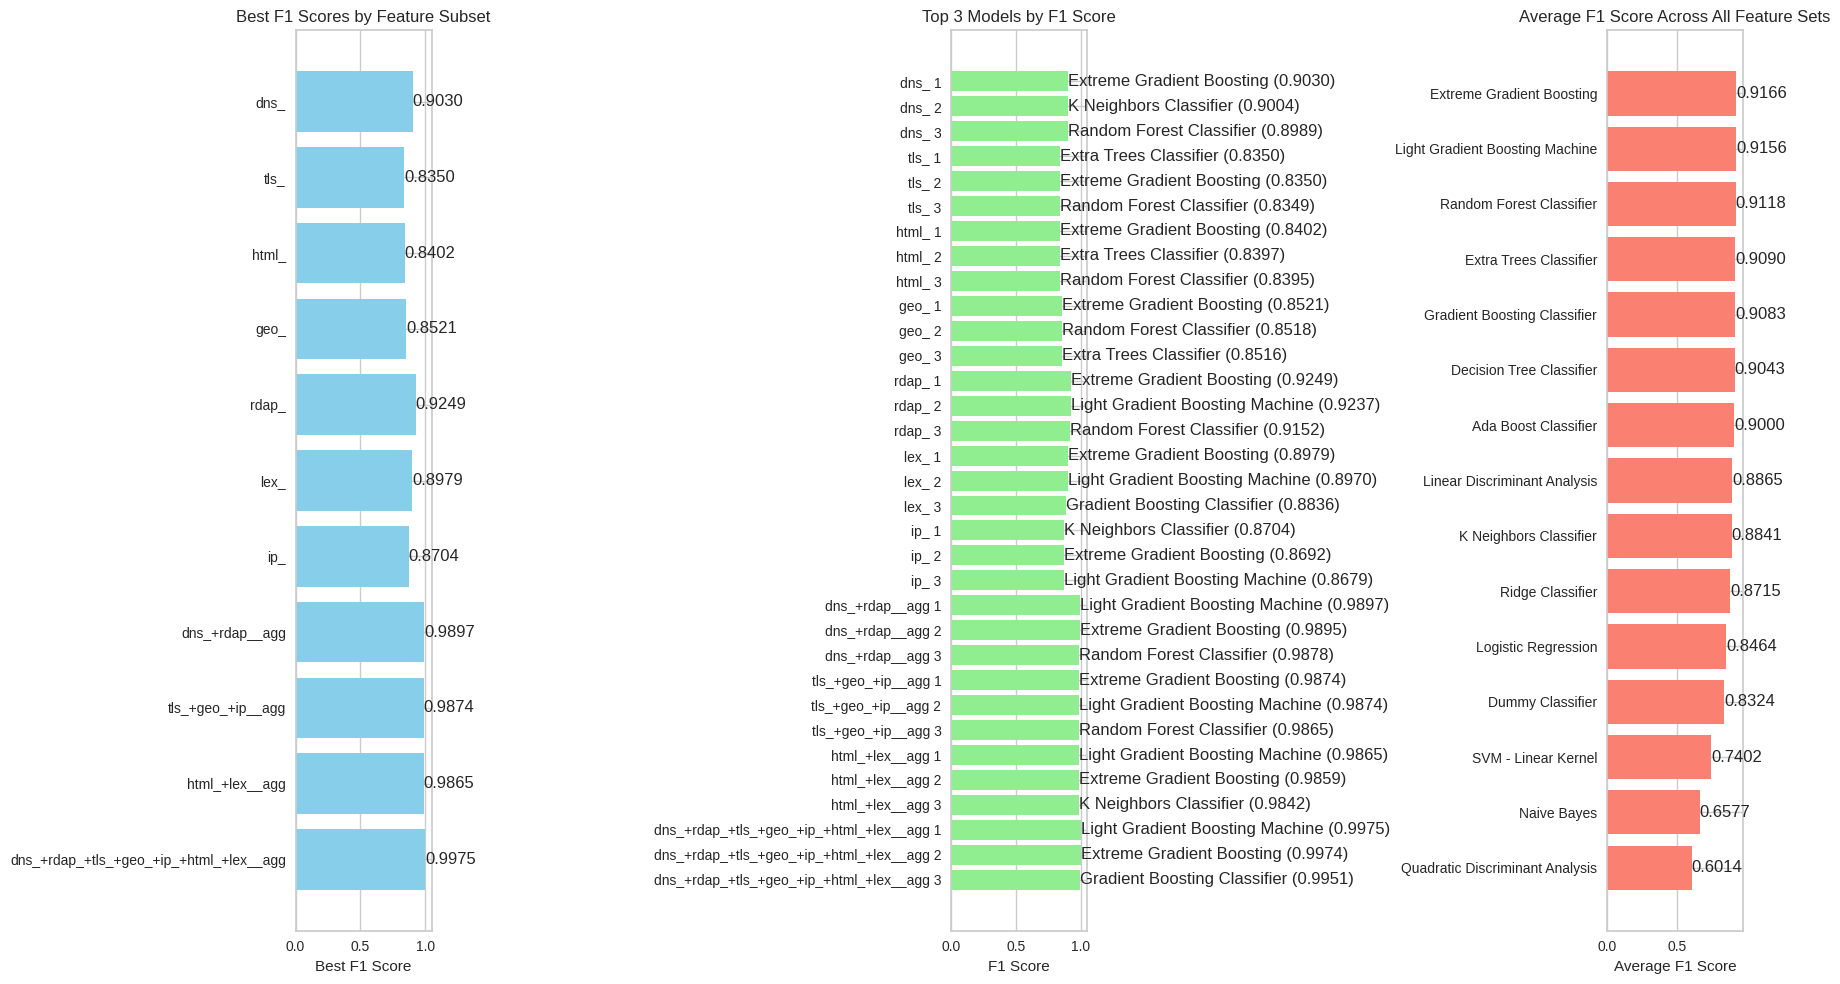

In [13]:
import matplotlib.pyplot as plt

# Extracting best F1 Scores and top models
best_f1_scores = []
model_names = []
subsets = []
top_models = {}

for prefix, grid in results_grids.items():
    # Best F1 score
    best_f1 = grid['F1'].max()
    best_f1_scores.append(best_f1)
    
    # Top 3 models
    top_3_models = grid.nlargest(3, 'F1')[['Model', 'F1']]
    top_models[prefix] = top_3_models
    model_names.append(top_3_models.iloc[0]['Model'])
    
    subsets.append(prefix)

# Initialize figure
plt.figure(figsize=(18, 10))

# Plot 1: Best F1 Scores by Feature Subset
plt.subplot(1, 3, 1)
bars = plt.barh(subsets, best_f1_scores, color='skyblue')
plt.xlabel('Best F1 Score')
plt.title('Best F1 Scores by Feature Subset')
plt.gca().invert_yaxis()
# Annotate exact F1 scores
for bar, score in zip(bars, best_f1_scores):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')

# Plot 2: Top Three Models for each Feature Subset
plt.subplot(1, 3, 2)
for i, (prefix, top_3) in enumerate(top_models.items()):
    for j, (index, row) in enumerate(top_3.iterrows()):
        plt.barh(f'{prefix} {j+1}', row['F1'], color='lightgreen')
        plt.text(row['F1'], i * 3 + j, f'{row["Model"]} ({row["F1"]:.4f})', va='center')
plt.title('Top 3 Models by F1 Score')
plt.xlabel('F1 Score')
plt.gca().invert_yaxis()

# Plot 3: Ranking of Models Across All Feature Sets
model_rankings = pd.concat([grid[['Model', 'F1']] for grid in results_grids.values()])
mean_f1_by_model = model_rankings.groupby('Model')['F1'].mean().sort_values(ascending=True)
plt.subplot(1, 3, 3)
bars = plt.barh(mean_f1_by_model.index, mean_f1_by_model, color='salmon')
plt.title('Average F1 Score Across All Feature Sets')
plt.xlabel('Average F1 Score')
# Annotate exact average F1 scores
for bar, score in zip(bars, mean_f1_by_model):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()



# TUNE MODELS

In [14]:
from pycaret.classification import tune_model, interpret_model

# Dictionary to store tuned models
tuned_models = {}

# Process each best model
for prefix, model in best_models.items():
    print(f"\n🔧 Tuning model for '{prefix}' features...")
    
    # Tune the model
    tuned = tune_model(model, optimize='F1')
    
    # Store the tuned model
    tuned_models[prefix] = tuned
    
    # Interpret the tuned model
    print(f"🔍 Interpreting tuned model for '{prefix}' features...")
    # Generate a SHAP plot for the tuned model using PyCaret's interpret_model
    interpret_model(tuned, plot='summary', save=True)
    # You can also display other types of plots by changing the 'plot' parameter value
    # For example, 'correlation' or 'reason' plots can also be useful




🔧 Tuning model for 'dns_' features...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9963,0.9999,0.9963,0.9963,0.9963,0.9811,0.9812
1,0.9968,0.9999,0.9968,0.9968,0.9968,0.9836,0.9836
2,0.9973,0.9999,0.9973,0.9973,0.9973,0.9861,0.9861
3,0.9973,0.9999,0.9973,0.9973,0.9973,0.9861,0.9862
4,0.9978,1.0000,0.9978,0.9978,0.9978,0.9887,0.9888
5,0.9974,0.9999,0.9974,0.9975,0.9975,0.9870,0.9870
6,0.9969,0.9998,0.9969,0.9970,0.9969,0.9844,0.9844
7,0.9964,0.9998,0.9964,0.9965,0.9964,0.9818,0.9819
8,0.9952,0.9998,0.9952,0.9953,0.9952,0.9758,0.9759


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
🔍 Interpreting tuned model for 'dns_' features...

🔧 Tuning model for 'tls_' features...


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:32:17
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

# Combine models

## Blended models 

In [ ]:
blender = blend_models(estimator_list = [gbc, light_model, xboost_model], method = 'soft')

## Boosted models

In [ ]:
stacker = stack_models(estimator_list = [gbc,light_model,xboost_model], meta_model=ada)

## Results

In [ ]:
plot_model(stacker)
plot_model(stacker, plot = 'confusion_matrix')
plot_model(stacker, plot = 'boundary')
interpret_model(stacker)
interpret_model(blender)